# Eigenfaces

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io

In [32]:
#pip install scipy
#pip install matplotib

In [3]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 18})

Leemos el contenido de la matriz de rostros:

In [4]:
mat_contents = scipy.io.loadmat(os.path.join('allFaces.mat'))

In [5]:
faces = mat_contents['faces']
m = int(mat_contents['m'])
n = int(mat_contents['n'])
nfaces = np.ndarray.flatten(mat_contents['nfaces'])

donde:

m, n es el ancho y el alto de cada foto en pixeles

In [6]:
print(m, n)

168 192


nfaces es el número de fotos que se tomaron de cada persona

In [7]:
print(nfaces)

[64 62 64 64 62 64 64 64 64 64 60 59 60 63 62 63 63 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64]


faces es la matriz que contiene todas las fotos de todas las personas en la base de datos. donde cada renglón es una foto vectorizada

In [8]:
faces.shape

(32256, 2410)

Grafiquemos la primer foto de cada una de las personas:

In [9]:
allPersons = np.zeros((n*6,m*6))
count = 0

In [10]:
#grafica la primera foto de cada una de las personas
for j in range(6):
    for k in range(6):
        allPersons[j*n : (j+1)*n, k*m : (k+1)*m] = np.reshape(faces[:,np.sum(nfaces[:count])],(m,n)).T
        count += 1

In [11]:
# la matriz allPersons es una matriz de 1152 x 1008
# donde 1152 = 6 * 192 y 1008 = 6 * 168
# ya que la matriz es de 6 imágenes por 6 imágenes
# cda entrada de la matriz describe un pixel de la imagen total

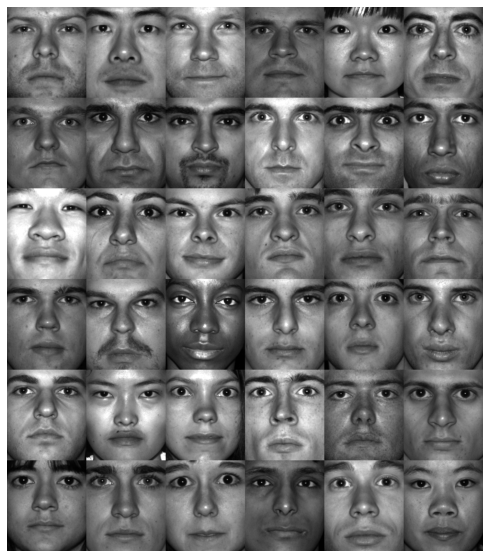

In [12]:
img = plt.imshow(allPersons)
img.set_cmap('gray')
plt.axis('off')
plt.show()

Ahora grafiquemos todas las fotos de todas las personas en la base de datos:

In [13]:
#for person in range(len(nfaces)):
#subset = faces[:,sum(nfaces[:person]) : sum(nfaces[:(person+1)])]
#allFaces = np.zeros((n*8,m*8))
#
#count = 0
#
#for j in range(8):
#for k in range(8):
#if count < nfaces[person]:
#allFaces[j*n:(j+1)*n,k*m:(k+1)*m] = np.reshape(subset[:,count],(m,n)).T
#count += 1
#img = plt.imshow(allFaces)
#img.set_cmap('gray')
#plt.axis('off')
#plt.show()

Ahora, separamos un conjunto de 36 caras para "entrenar" nuestro algoritmo:

In [14]:
training_faces = faces[:, :np.sum(nfaces[:5])]

In [15]:
training_faces.shape

(32256, 316)

Calculamos el promedio sobre todas las fotos de estas 36 caras para obtener la cara promedio

In [16]:
avg_face = np.mean(training_faces, axis=1)

La cara promedio:

(-0.5, 167.5, 191.5, -0.5)

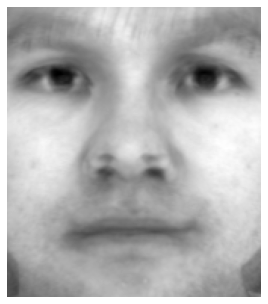

In [17]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
img_avg = ax1.imshow(np.reshape(avg_face,(m,n)).T)
img_avg.set_cmap('gray')
plt.axis('off')

Le restamos este promedio a todos los vectores (columnas?) de la matriz para centrar los datos

In [18]:
X = training_faces - np.tile(avg_face,(training_faces.shape[1], 1)).T
#aquí creo no entendí bien, por que saca el promedio por renglon pero luego se lo resta a las columnas :S perdón, amigos

In [19]:
# importamos los paquetes de nuestro algoritmo
from svd_jacobi import sign
from svd_jacobi import ortogonalidad
from svd_jacobi import seno_coseno
from svd_jacobi import actualizar_AV
from svd_jacobi import jacobi_one_sided
from svd_jacobi import normalizacion_A

In [20]:
A,V = jacobi_one_sided(X,5)

1
2
3
4
5


Obtenemos la descomposición en valores singulares con linalg de numpy

In [23]:
U = normalizacion_A(A)

In [24]:
#U, S, VT = np.linalg.svd(X, full_matrices=0)
VT = V.T

En la matrix U tenemos una base ortonormal para representar a las caras, los vectores de esta base se conocen como eigenfaces

Por ejemplo, veamos la primera *eigenface*:

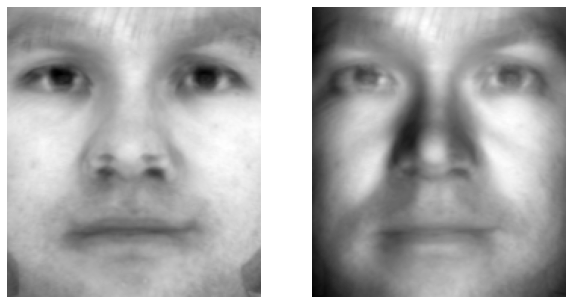

In [25]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
img_avg = ax1.imshow(np.reshape(avg_face,(m,n)).T)
img_avg.set_cmap('gray')
plt.axis('off')

ax2 = fig1.add_subplot(122)
img_u1 = ax2.imshow(np.reshape(U[:,0],(m,n)).T)
img_u1.set_cmap('gray')
plt.axis('off')

#aquí no entiendo bien lo de subplot

plt.show()

### Reconstrucción de una cara test
Las caras 37 y 38 no fueron utilizadas para "entrenar" el algoritmo. Veamos que podemos reconstruir estas caras nuevas con un subconjunto de nuestras eigenfaces.

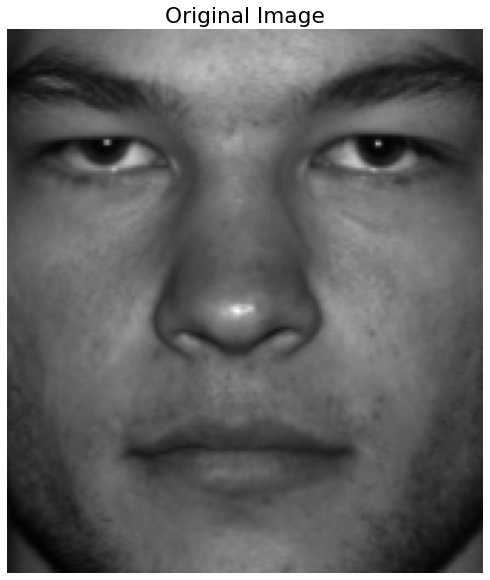

In [29]:
test_face = faces[:,np.sum(nfaces[:36])] # Primera foto de la persona 37
plt.imshow(np.reshape(test_face,(m,n)).T)
plt.set_cmap('gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

La razón por la que podemos hacer una aproximación a cada cara con un subconjunto de eigenfaces es por que podemos aproximar X como:
$$ \hat{X} \approx U_r \Sigma_r V_r^T$$
Entonces podemos poner
$$ \alpha = U_r^T x$$
como el vector que contiene la información de que tanto se necesita de cada eigenface para reconstruir a x (i.e. combinación lineal de eigenfaces). Es este espacio cada $\alpha$ es única para cada cara. Entonces una aproximación de $x$ tomando únicamente $r$ eigenfaces sería:
$$\hat{x} = U_r U_r^T x$$

Esta es una compresión muy grande pues para guardar una foto en vex de utilizar los 168 x 192 pixeles únicamente necesitariamos un vector de tamaño $r$ para representar todas las caras del mundo.

In [30]:
test_face_MS = test_face - avg_face #MS = Mean - Substracted
r_list = [25, 50]#, 100, 200, 400, 800, 1600]

In [31]:
for r in r_list:
    recon_face = avg_face + U[:,:r]  @ U[:,:r].T @ test_face_MS
    img = plt.imshow(np.reshape(recon_face,(m,n)).T)
    img.set_cmap('gray')
    plt.title('r = ' + str(r))
    plt.axis('off')
    plt.show()

MemoryError: Unable to allocate 7.75 GiB for an array with shape (32256, 32256) and data type float64

Y notamos que obtenemos una muy buena aproximación usando sólo 1600 vectores de U.

## Proyectar a las personas 1 y 7 en PC5 y PC6

In [29]:
P1_num = 2 # Persona 2
P2_num = 7 # Persona 7

In [30]:
P1 = faces[:, np.sum(nfaces[:(P1_num - 1)]):np.sum(nfaces[:P1_num])]
P2 = faces[:, np.sum(nfaces[:(P2_num - 1)]):np.sum(nfaces[:P2_num])]

In [31]:
P1 = P1 - np.tile(avg_face,(P1.shape[1], 1)).T
P2 = P2 - np.tile(avg_face,(P2.shape[1], 1)).T

In [32]:
pca_modes = [5, 6] # Project onto PCA modes 5 and 6
pca_coordsP1 = U[:, pca_modes - np.ones_like(pca_modes)].T @ P1
pca_coordsP2 = U[:, pca_modes - np.ones_like(pca_modes)].T @ P2

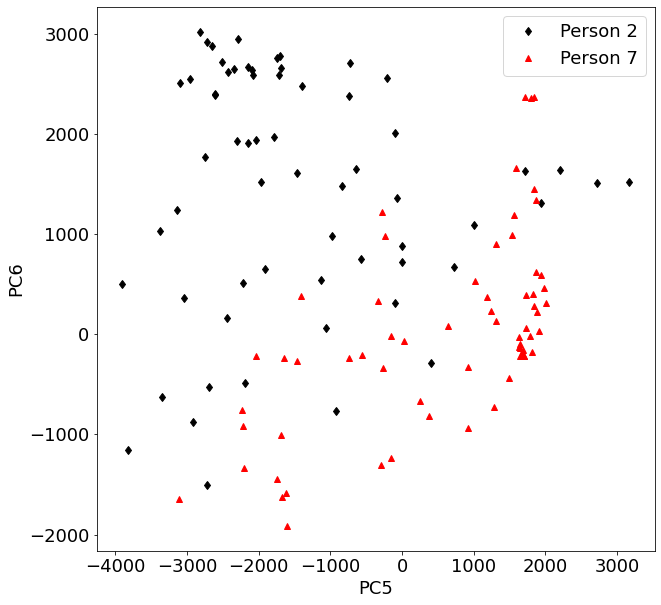

In [48]:
plt.plot(pca_coordsP1[0, :], pca_coordsP1[1, :], 'd', color='k', label='Person 2')
plt.plot(pca_coordsP2[0, :], pca_coordsP2[1, :], '^', color='r', label='Person 7')
plt.xlabel("PC5")
plt.ylabel("PC6")
plt.legend()
plt.show()